In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ipba-13-nlp-with-disaster-tweets/sample_submission.csv
/kaggle/input/ipba-13-nlp-with-disaster-tweets/train.csv
/kaggle/input/ipba-13-nlp-with-disaster-tweets/test.csv


# 1. Importing Libraries

In [2]:
import re #regex applies a regular expression to a string and returns the matching substrings. 
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk 
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import BlanklineTokenizer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
import string
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
import scikitplot as skplt
from nltk.tokenize import word_tokenize
import gensim
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Import Datasets

In [3]:
train = pd.read_csv('/kaggle/input/ipba-13-nlp-with-disaster-tweets/train.csv')
test = pd.read_csv('/kaggle/input/ipba-13-nlp-with-disaster-tweets/test.csv')
ss = pd.read_csv('/kaggle/input/ipba-13-nlp-with-disaster-tweets/sample_submission.csv')

### 2.1 Data Check

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Checking Data Type
train.dtypes, test.dtypes

(id           int64
 keyword     object
 location    object
 text        object
 target       int64
 dtype: object,
 id           int64
 keyword     object
 location    object
 text        object
 dtype: object)

In [6]:
train.shape, test.shape, test.shape[0]/train.shape[0]

((7613, 5), (3263, 4), 0.4286089583606988)

In [7]:
null_train = pd.DataFrame({"num_null": train.isnull().sum()})
null_train["perc_null"] = null_train["num_null"] / train.count() * 100
null_train

,num_null,perc_null
id,0,0.000000
keyword,61,0.807733
location,2533,49.862205
text,0,0.000000
target,0,0.000000


In [8]:
null_test = pd.DataFrame({"num_null": test.isnull().sum()})
null_test["perc_null"] = null_test["num_null"] / test.count() * 100
null_test

,num_null,perc_null
id,0,0.000000
keyword,26,0.803213
location,1105,51.204819
text,0,0.000000


# 3. Exploratory Data Analysis

Cheking the Class Distribution of Disaster and Non-Disaster related tweets

Text(0, 0.5, 'Samples')

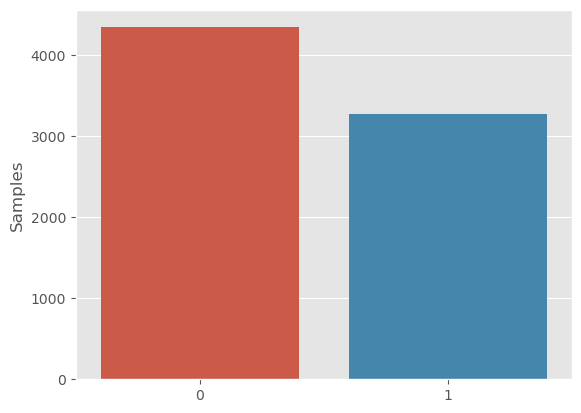

In [9]:
x = train.target.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('Samples')

What are the top 30 Keywords?
- Disastor Tweets
- Non-Disaster Tweets

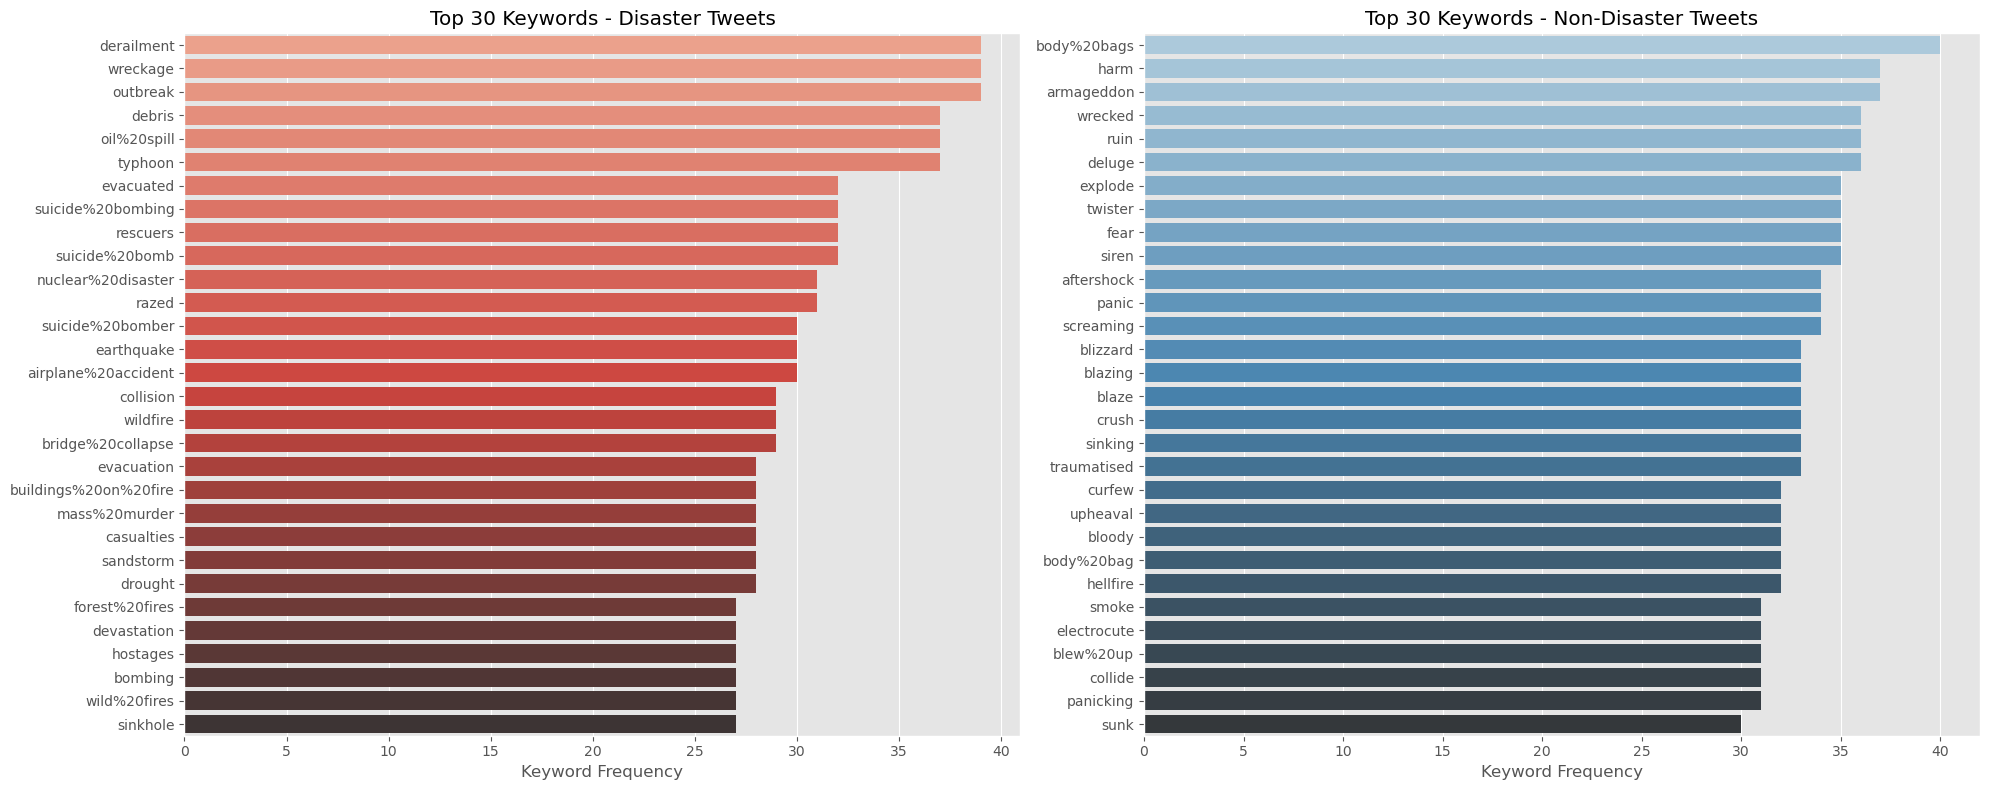

In [10]:
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:30].index, x=disaster_keywords[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_keywords[0:30].index, x=nondisaster_keywords[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

Average Word Length of the Tweets?

Text(0.5, 0.98, 'Average word length in each tweet')

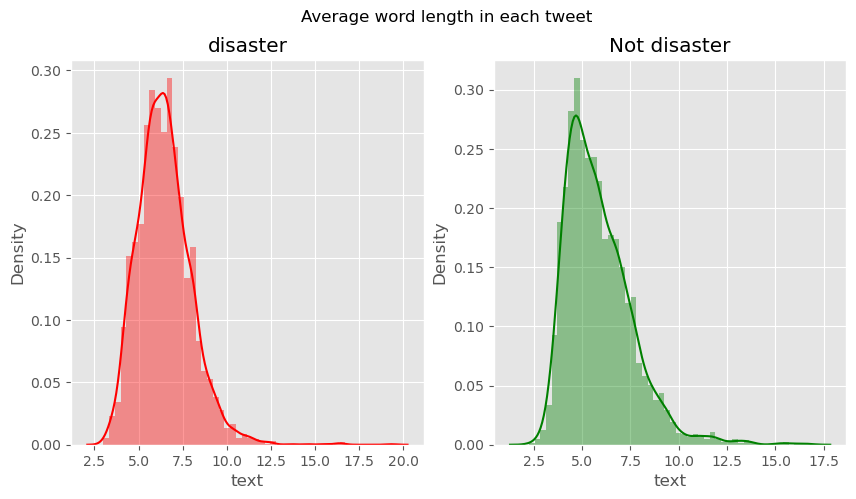

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

Calculating the probability of disaster on appearance of a particular keyword

In [12]:
keywords_vc = pd.DataFrame({"Count": train["keyword"].value_counts()})
def keyword_disaster_probabilities(x):
    tweets_w_keyword = np.sum(train["keyword"].fillna("").str.contains(x))
    tweets_w_keyword_disaster = np.sum(train["keyword"].fillna("").str.contains(x) & train["target"] == 1)
    return tweets_w_keyword_disaster / tweets_w_keyword

keywords_vc["Disaster_Probability"] = keywords_vc.index.map(keyword_disaster_probabilities)
keywords_vc.head()

,Count,Disaster_Probability
fatalities,45,0.577778
deluge,42,0.188406
armageddon,42,0.119048
sinking,41,0.195122
damage,41,0.463415


Cardinality and Target Distribution

In [13]:
print(f'Number of unique values in keyword = {train["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {train["location"].nunique()} (Training) - {test["location"].nunique()} (Test)')

Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


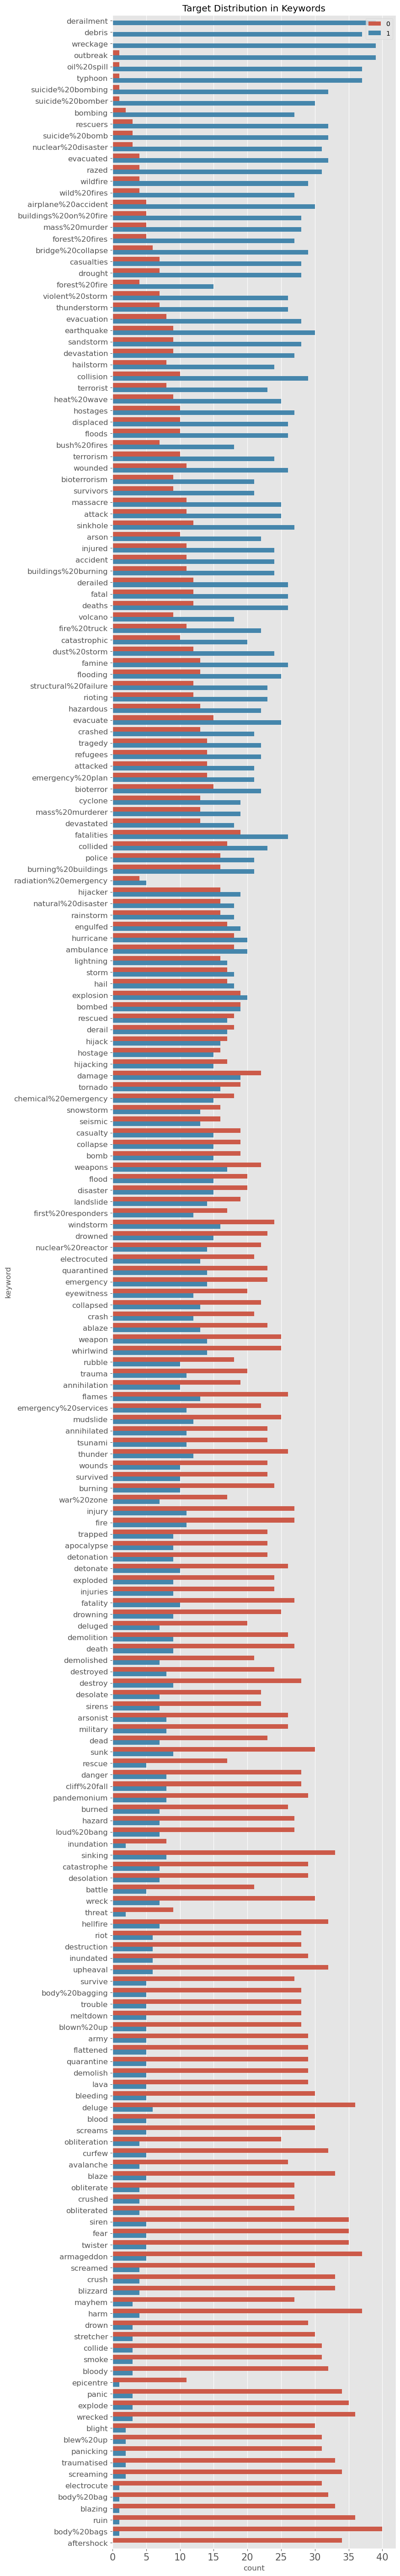

In [14]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

# 4. Punctuation Removal and Conversion to lower case

In [15]:
def  preprocess_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower() #Convert strings in the Series/Index to lowercase.
    
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    #remove url
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"https?://\S+|www\.\S+", "", elem))
    #remove HTML tags
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"<.*?>", "", elem))
    #remove emojis 
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", "", elem))
    return df
data_clean = preprocess_text(train, 'text', 'text_clean')
data_clean_test = preprocess_text(test,'text', 'text_clean')
data_clean.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


# 5. Removing Stop Words and Tokenizing

## 5.1 Stop words Removal

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
data_clean['text_clean'] = data_clean['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_clean.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason #earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...


## 5.2 Tokenization

In [17]:
from nltk.tokenize import sent_tokenize, word_tokenize
data_clean['text_tokens'] = data_clean['text_clean'].apply(lambda x: word_tokenize(x))
data_clean.head()

,id,keyword,location,text,target,text_clean,text_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason #earthquake may allah forgive us,"[deeds, reason, #, earthquake, may, allah, for..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, ., canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...,"[residents, asked, 'shelter, place, ', notifie..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ...","[,, people, receive, #, wildfires, evacuation,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...,"[got, sent, photo, ruby, #, alaska, smoke, #, ..."


# 6. Stemming

In [18]:
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text
data_clean['text_clean_tokens'] = data_clean['text_tokens'].apply(lambda x: word_stemmer(x))
data_clean.head()

,id,keyword,location,text,target,text_clean,text_tokens,text_clean_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason #earthquake may allah forgive us,"[deeds, reason, #, earthquake, may, allah, for...","[deed, reason, #, earthquak, may, allah, forgi..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, rong, sask, ., canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...,"[residents, asked, 'shelter, place, ', notifie...","[resid, ask, 'shelter, place, ', notifi, offic..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ...","[,, people, receive, #, wildfires, evacuation,...","[,, peopl, receiv, #, wildfir, evacu, order, c..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...,"[got, sent, photo, ruby, #, alaska, smoke, #, ...","[got, sent, photo, rubi, #, alaska, smoke, #, ..."


# 7. Splitting the Data

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(data_clean['text_clean'], 
                   
                                                    data_clean['target'], 
                                                    test_size = 0.2,
                                                    random_state = 10)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6090,)
(1523,)
(6090,)
(1523,)


# 8. Tranformation  to TF-IDF

### CountVectorizer

In [21]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(), 
            index=['sentence '+str(i) 
                   for i in range(1, 1+len(X_train))],
            columns=vectorizer.get_feature_names())

,__,__ohhmyjoshh,__scrambledeggs,__srajapakse__,_animaladvocate,_ashj,_asianshawtyy,_bookofdaniel,_charleyisqueen,_dangdaddy,...,ûïyou,ûò,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûónegligence,ûótech,ûówe
sentence 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 6086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#Only alphabet, contains at least 3 letters
vectorizer = CountVectorizer(analyzer='word', 
                              token_pattern=r'\b[a-zA-Z]{3,}\b',  
                              ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(), 
             index=['sentence '+str(i) 
                    for i in range(1, 1+len(X_train))],
             columns=vectorizer.get_feature_names())

,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aal,aan,aannnnd,aashiqui,aba,abandon,...,zones,zoom,zotar,zouma,zourryart,zrnf,zss,zumiez,zxathetis,zzzz
sentence 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 6086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Consider only unigrams/bigrams/… tokens

- ngram-range=(1, 1): unigram only
- ngram-range=(2, 2): bigrams only
- ngram-range=(1, 2): both unigrams and bigrams

In [23]:
vectorizer = CountVectorizer(analyzer='word', 
                              token_pattern=r'\b[a-zA-Z]{3,}\b',  
                              ngram_range=(2, 2))  # only bigrams
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(), 
             index=['sentence '+str(i) 
                    for i in range(1, 1+len(X_train))],
             columns=vectorizer.get_feature_names())

,aaaa lemme,aaaaaaallll even,aaaaaand there,aan den,aannnnd reddit,aashiqui actress,aba woman,abandon plans,abandon west,abandoned aircraft,...,zone war,zones don,zoom one,zotar skeleton,zouma absolutely,zouma flattened,zourryart forgot,zss sws,zumiez location,zxathetis are
sentence 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 6086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Consider only tokens with certain frequency

In [24]:
# consider both unigrams and bigrams, occur at least twice
vectorizer = CountVectorizer(analyzer='word', 
                              token_pattern=r'\b[a-zA-Z]{3,}\b',  
                              ngram_range=(1, 2),                                             min_df = 2)  
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(), 
             index=['sentence '+str(i) 
                    for i in range(1, 1+len(X_train))],
             columns=vectorizer.get_feature_names())

,aba,aba woman,abandon,abandoned,abandoned aircraft,abbott,abbswinston,abbswinston zionist,abc,abc news,...,zionist terrorist,zippednews,zombie,zombie apocalypse,zone,zone coming,zouma,zouma flattened,zss,zss sws
sentence 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 6086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 6089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TFIDFtransformer

In [25]:
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfVectorizer,
                                             TfidfTransformer)
vectorizer = CountVectorizer(analyzer='word', 
                              token_pattern=r'\b[a-zA-Z]{3,}\b',  
                              ngram_range=(1, 1) 
                              )  
count_vectorized = vectorizer.fit_transform(X_train)
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
train_features = tfidf.fit_transform(count_vectorized).toarray()

pd.DataFrame(train_features, 
             index=['sentence '+str(i) 
                    for i in range(1, 1+len(X_train))],
             columns=vectorizer.get_feature_names())

,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aal,aan,aannnnd,aashiqui,aba,abandon,...,zones,zoom,zotar,zouma,zourryart,zrnf,zss,zumiez,zxathetis,zzzz
sentence 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 6086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 6087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 6088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 6089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TFIIDFvectorizer

In [26]:
# Convert a collection of text documents to a matrix of token counts
tfidf = feature_extraction.text.TfidfVectorizer(encoding='utf-8',
                       ngram_range=(1,1),
                       max_features=5000,
                       norm='l2',
                       sublinear_tf=True)

In [27]:
train_features = tfidf.fit_transform(X_train).toarray()

In [28]:
print(train_features[1])
print(train_features.shape)

[0. 0. 0. ... 0. 0. 0.]
(6090, 5000)


In [29]:
pd.DataFrame(train_features, 
             index=['sentence '+str(i) 
                    for i in range(1, 1+len(X_train))],
             columns=tfidf.get_feature_names())

,__,aa,aba,abandoned,abbswinston,abc,abcnews,abe,ability,ablaze,...,ûï,ûïa,ûïhatchet,ûïrichmond,ûïthe,ûïwe,ûïwhen,ûïyou,ûò,ûó
sentence 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 6086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 6087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 6088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 6089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
dic_vocabulary = tfidf.vocabulary_

In [31]:
test_features = tfidf.transform(X_test).toarray()
print(test_features.shape)

(1523, 5000)


In [32]:
train_labels = Y_train
test_labels = Y_test

# 9. Model Building

## Multinominal Naive Bayes

In [33]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [34]:
mnb_classifier = MultinomialNB()

In [35]:
mnb_classifier.fit(train_features,train_labels)

MultinomialNB()

In [36]:
mnb_prediction = mnb_classifier.predict(test_features)

## Visualizing scikit model performance

In [37]:
training_accuracy = accuracy_score(train_labels, mnb_classifier.predict(train_features))
print(training_accuracy)

0.8694581280788177


In [38]:
testing_accuracy = accuracy_score(test_labels, mnb_prediction)
print(testing_accuracy)

0.7898883782009193


In [39]:
print(classification_report(test_labels, mnb_prediction))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       861
           1       0.83      0.65      0.73       662

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [40]:
conf_matrix = confusion_matrix(test_labels, mnb_prediction)
print(conf_matrix)

[[771  90]
 [230 432]]


<AxesSubplot:>

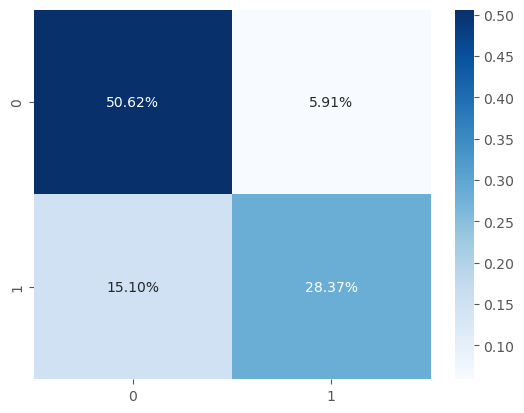

In [41]:
sns.heatmap(conf_matrix/np.sum(conf_matrix),annot=True, fmt='.2%', cmap='Blues')

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(train_features, train_labels)

In [43]:
predicts = knn.predict((test_features))
print(classification_report(test_labels, predicts)) 

              precision    recall  f1-score   support

           0       0.64      0.99      0.78       861
           1       0.96      0.27      0.43       662

    accuracy                           0.68      1523
   macro avg       0.80      0.63      0.60      1523
weighted avg       0.78      0.68      0.63      1523



# 10. Creating Submission File

## Fitting Test Data

In [44]:
test_vectorizer =tfidf.transform( data_clean_test['text_clean']).toarray()

In [45]:
final_predictions = mnb_classifier.predict(test_vectorizer)

In [46]:
final_predictions

array([1, 0, 0, ..., 1, 1, 1])

# 11. Exporting Submission File

In [47]:
submission = pd.DataFrame()

In [48]:
submission['id'] = data_clean_test['id']
submission['target'] = final_predictions

In [49]:
submission

,id,target
0,0,1
1,2,0
2,3,0
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [50]:
submission['target'].value_counts()

0    2283
1     980
Name: target, dtype: int64

In [51]:
submission_1 = submission.to_csv('submission.csv',index = False)